<h1 style="text-align: center;  font-weigth: bold; margin-top: 20px;">
  Visual exploratory data analysis with python and pydeck
</h1>
<h2 style="text-align: center; margin-bottom: 10px;">
  Lorenzo Perozzi
</h2>
<p style="text-align: center; margin-bottom: 20px;">
   <a href="https://www.unige.ch/ge-rgba/welcome/">GE-RGBA Group, Departement of Earth Science, University of Geneva</a>
</p>
<div align="center" style="margin-bottom: 20px;">
    <img src="src/logo.png" style="height: 70px">
</div>


 
## About

During this tutorial, it will be shown how to use python to process and visualize a dataset about geothermal probes availability in the Canton of Geneva. This dataset can be obtained (open access) through the <a href="https://ge.ch/sitg/fiche/6867 ">SITG</a> (Système d’Information du Territoire à Genève). We will cover these a spects:

- Load the geothermal probes dataset.
- Convert CRS coordinate system with **pyproj**
- Extract depth information form attributes
- Visualising the results with **pydeck**

|         | Info |
|--------:|:-----|
| When | Friday, October 1st • 12:30 - 13:00  |
| Live stream | https://youtu.be/0bxZcCAr6bw |
| conda environment  | `DST-geothermal-visual` |
| Deck.gl documentation | https://deck.gl/ |


## Setup

If you want to follow along the tutorial, make sure you've done these steps **before the tutorial begin**:

### Step 1

**Install a Python distribution:**

In this tutorial we will be using the [Anaconda](https://www.anaconda.com/)
Python distribution along with the `conda` package manager. If you already have
Anaconda or Miniconda installed, you can skip this step.

If not, please follow the instructions for getting Anaconda up and running in
your system: https://docs.anaconda.com/anaconda/install/

### Step 2

**Create the `DST-geothermal-visual` conda environment:**

1. Download the `environment.yml` file from
   [here](https://raw.githubusercontent.com/fatiando/transform21/master/environment.yml)
   (right-click and select "Save page as" or similar)
1. Make sure that the file is called `environment.yml`. Windows sometimes adds a
   `.txt` to the end, which you should remove.
1. Open a terminal (*Anaconda Prompt* if you are running Windows). The
   following steps should be done in the terminal.
1. Navigate to the folder that has the downloaded environment file
   (if you don't know how to do this, take a moment to read [the Software
   Carpentry lesson on the Unix shell](http://swcarpentry.github.io/shell-novice/)).
1. Create the conda environment by running `conda env create --file environment.yml`
   (this will download and install all of the packages used in the tutorial).
1. **Windows users:** Make sure you set a default browser that is **not Internet Explorer**.
1. Activate the conda environment: `conda activate DST-geothermal-visual`
1. Create a new kernel for this environment environment: `ipython kernel install --user --name=<any_name_for_kernel>`
1. Start the JupyterLab server: `jupyter lab`
1. Jupyter should open in your default web browser. We'll start from here in the
   tutorial and create a new notebook together.
   
   
<div style="text-align: left; margin-bottom: 100px;">

 </div>

Importing packages

In [1]:
import pydeck
import pandas as pd
import numpy as np
import matplotlib.cm
import matplotlib.pyplot as plt

## Load and inspect the geothermal probes dataset
The dataset is stored on the [SITG](https://ge.ch/sitg/fiche/6867) (Système d'information du territoire à Genève) and publicly available. 

In [2]:
filename = 'data/CSV_CTSS_CHAUFFAGE_SONDE/CTSS_CHAUFFAGE_SONDE.csv'

To open the dataset we use the [`Pandas`](https://pandas.pydata.org/docs/) package. By default in a `csv`file, columns are separated by a comma `,`, however, we can specify which method is used to spearate the columns. Since the columns in this files are separated by a semicolon, we need to specify the `sep` arguments in the `pd.read_csv` class.

In [3]:
sondes = pd.read_csv(filename, encoding='latin-1', sep=';')

We can inspect the dataset. For example we can inspect the first 5 lines of the file

In [4]:
sondes.head(5)

,ID_SONDE,ID_DOSSIER,ALTITUDE_MIN,ALTITUDE_MAX,DIMENSION,FLUIDE,ETAT,DETERMINATION_PLANIMETRIQUE,REMARQUES,E,N
0,NaN,APA 29428,0.0,0.0,Diamètre 32mm/40mm Profondeur 130m,Glycol / Alcoll 30 %,En service,Précis,Selon plan d'implantation,2503134.19,1116687.02
1,NaN,DD103532,0.0,0.0,Profondeur 150m,Inconnu,En service,Précis,Selon plan d'implantation,2503969.64,1117479.52
2,NaN,DD103532,0.0,0.0,Profondeur 150m,Inconnu,En service,Précis,Selon plan d'implantation,2503973.68,1117475.11
3,NaN,DD 103116,0.0,0.0,Diamètre 32mm Profondeur 126m,Inconnu,En service,Précis,NaN,2500384.43,1124679.20
4,NaN,DD 103116,0.0,0.0,Diamètre 32mm Profondeur 126m,Inconnu,En service,Précis,NaN,2500393.94,1124689.78


We also can inspect more information about the file

In [5]:
sondes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2033 entries, 0 to 2032
Data columns (total 11 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   ID_SONDE                     170 non-null    object 
 1   ID_DOSSIER                   1933 non-null   object 
 2   ALTITUDE_MIN                 1888 non-null   float64
 3   ALTITUDE_MAX                 1965 non-null   float64
 4   DIMENSION                    1548 non-null   object 
 5   FLUIDE                       2031 non-null   object 
 6   ETAT                         1989 non-null   object 
 7   DETERMINATION_PLANIMETRIQUE  1982 non-null   object 
 8   REMARQUES                    481 non-null    object 
 9   E                            2033 non-null   float64
 10  N                            2033 non-null   float64
dtypes: float64(4), object(7)
memory usage: 174.8+ KB


The file contains 11 columns (attributes) and 2033 entries. The scope here is to analyse/visualize the geothermal probes using `pydeck`, an high-scale spatial rendering powered by [deck.gl](https://deck.gl/#/). We need at least 3 attributes: the spatial coordinates (`X` and `Y`) as well as the depth of each probes.

We remark that the only attributes that do not have `NaN`values are `E` and `N`that are the Easting and Northing coordinates.

In [6]:
sondes[['E','N']].head(5)

,E,N
0,2503134.19,1116687.02
1,2503969.64,1117479.52
2,2503973.68,1117475.11
3,2500384.43,1124679.20
4,2500393.94,1124689.78


To visualize the data with pydeck (and in general with all geospatial visualation packages) we need to work on *World Geodetic System 1984 - WGS84* (also know as EPSG:4326). In our dataset, `E`and `N` are in the CH1903+_LV95 reference system (also known as EPSG:2056). 

The fisrt step will then to reproject the data from the EPSG:2056 system to the EPSG:4326 system

## Reproject coordinate form EPSG:2056 to EPSG:4326

There are several online converter for that such as [EPSG.io](https://epsg.io/), that works well when we have few set of coordinates to transform. However, to be effcient, we use `pyproj` that is a Python interface to [PROJ](https://proj.org/) (cartographic projections and coordinate transformations library).

In [7]:
from pyproj import Transformer
from pyproj import CRS

1. Initializing CRS and create transformer to convert form 2056 to 4326

In [8]:
crs_4326 = CRS.from_epsg(4326)
crs_2056 = CRS.from_epsg(2056)
transformer = Transformer.from_crs(crs_2056, crs_4326)

2. Convert `E` and `N` to `Latitude` and `Longitude` respectively

In [9]:
sondes['lat'], sondes['lon'] = transformer.transform(sondes.E.values, sondes.N.values)

In [10]:
sondes[['E','N','lat','lon']].head(5)

,E,N,lat,lon
0,2503134.19,1116687.02,46.194656,6.183829
1,2503969.64,1117479.52,46.201904,6.194487
2,2503973.68,1117475.11,46.201865,6.194540
3,2500384.43,1124679.20,46.266139,6.146507
4,2500393.94,1124689.78,46.266236,6.146628


One attribute we want to inspect is the depth of the probes. In the dataset we do not have an attributes for that, we need further inspection. Among the 11 columns we have `ALTITUDE_MIN`, `ALTITUDE_MAX` and `DIMENSION` that should give us this information. However this attributes contains several `NaN`. Let inspect these attributes. 

## Retrieve depth of geothermal probes


In [11]:
sondes[['ALTITUDE_MIN','ALTITUDE_MAX','DIMENSION']].sample(8, random_state=51)

,ALTITUDE_MIN,ALTITUDE_MAX,DIMENSION
1024,0.0,374.0,Diamètre 4x32mm Profondeur 137m
1255,0.0,393.8,Diamètre 40mm Profondeur 185m
907,0.0,0.0,diamètre 32mm profondeur 290m
1763,0.0,0.0,NaN
1181,0.0,455.5,4x diamètre 32mm Profondeur 85m
1136,NaN,451.3,Diamètre 4x32mm Profondeur 140m
18,0.0,0.0,Profondeur 90m
1301,0.0,0.0,NaN


We have several case: 
1. `NaN` everywhere, we will drop these lines while useless
1. Depth information contained in the `DIMENSION` attributes, as a string text
1. Depth information contained in the (`ALTITUDE_MAX` - `ALTITUDE_MIN`) attributes, as a string text

Note: Normally, with `pd.read_csv()` the `NaN` are automatically detected, however, depending how the data have been compiled, it is not always the case. For example here, the `0.0` value in `ALTITUDE_MAX` or `ALTITUDE_MIN` attribute, correspond clearly to `NaN` values. 

The next step will be to clean up all lines that contains `NaN`.


In [12]:
sondes.replace(to_replace=0.0, value=np.NaN, inplace=True)
sondes[['ALTITUDE_MIN','ALTITUDE_MAX','DIMENSION']].sample(8, random_state=51)

,ALTITUDE_MIN,ALTITUDE_MAX,DIMENSION
1024,NaN,374.0,Diamètre 4x32mm Profondeur 137m
1255,NaN,393.8,Diamètre 40mm Profondeur 185m
907,NaN,NaN,diamètre 32mm profondeur 290m
1763,NaN,NaN,NaN
1181,NaN,455.5,4x diamètre 32mm Profondeur 85m
1136,NaN,451.3,Diamètre 4x32mm Profondeur 140m
18,NaN,NaN,Profondeur 90m
1301,NaN,NaN,NaN


Then we remove all rows with `NaN` in `ALTITUDE_MAX`, `ALTITUDE_MIN`, `DIMENSION`

In [13]:
sondes.dropna(subset=['ALTITUDE_MIN', 'ALTITUDE_MAX', 'DIMENSION'], thresh=2, inplace=True)
sondes[['ALTITUDE_MIN','ALTITUDE_MAX','DIMENSION']].sample(8, random_state=51)

,ALTITUDE_MIN,ALTITUDE_MAX,DIMENSION
390,233.110001,393.109985,"Long.max.160ml,4 sondes diam.34mm par tube"
948,134.000000,404.000000,NaN
1485,300.000000,433.000000,NaN
861,NaN,395.500000,Diamètre 4x40mm Profondeur 135m
1080,NaN,434.700000,Profondeur 135m
373,303.799988,428.799988,Long. totale = 125ml / Diam. 4 x 32
822,NaN,383.000000,Diamètre 4x32mm Profondeur 150m
1129,NaN,433.900000,Diamètre 4x 32mm Profondeur 160m


We then need to create a `DEPTH` attributes that retrieve geothermal probe information from `ALTITUDE_MIN` and `ALTITUDE_MAX`, if these attributes do not contains `NaN`...

In [14]:
sondes.reset_index(inplace=True)
idx1 = np.where((~np.isnan(sondes['ALTITUDE_MIN'].values)) & (~np.isnan(sondes['ALTITUDE_MAX'].values)))
sondes['DEPTH'] = np.nan
sondes['DEPTH'].loc[idx1] = sondes.ALTITUDE_MAX - sondes.ALTITUDE_MIN
sondes[['ALTITUDE_MIN','ALTITUDE_MAX','DIMENSION', 'DEPTH']].sample(8, random_state=2)

/Users/lorenzoperozzi/opt/anaconda3/envs/DST-geothermal-visual/lib/python3.9/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


,ALTITUDE_MIN,ALTITUDE_MAX,DIMENSION,DEPTH
550,NaN,400.0,diamètre 4x40mm Profondeur 200m,NaN
792,NaN,384.1,Diamètre 4x40mm Profondeur 180m,NaN
682,NaN,460.0,Diamètre 32mm Profondeur 120m,NaN
1221,NaN,453.6,Profondeur 85m,NaN
169,222.0,422.0,NaN,200.0
1212,228.0,428.0,Prof.220m.,200.0
181,273.0,433.0,NaN,160.0
481,NaN,395.5,Diamètre 4x32mm Profondeur 130m,NaN


... or form the `DIMENSION`column. This attribute is a string, from which we need to extract depth information. For this end we use Regular Expression for extracting one or more digit with `str.extract('(\d+)')` from the last 5 character of the `DIMENSION` string text

In [15]:
idx2 = np.where((np.isnan(sondes['DEPTH'].values)))
sondes['DEPTH'].loc[idx2] = sondes['DIMENSION'].loc[idx2].str[-5:].str.extract('(\d+)', expand=False).astype(np.float32)
sondes[['ALTITUDE_MIN','ALTITUDE_MAX','DIMENSION', 'DEPTH']].sample(8, random_state=2)

/Users/lorenzoperozzi/opt/anaconda3/envs/DST-geothermal-visual/lib/python3.9/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


,ALTITUDE_MIN,ALTITUDE_MAX,DIMENSION,DEPTH
550,NaN,400.0,diamètre 4x40mm Profondeur 200m,200.0
792,NaN,384.1,Diamètre 4x40mm Profondeur 180m,180.0
682,NaN,460.0,Diamètre 32mm Profondeur 120m,120.0
1221,NaN,453.6,Profondeur 85m,85.0
169,222.0,422.0,NaN,200.0
1212,228.0,428.0,Prof.220m.,200.0
181,273.0,433.0,NaN,160.0
481,NaN,395.5,Diamètre 4x32mm Profondeur 130m,130.0


Now, we all the information we need visualize geothermal probes with `pydeck`

In [16]:
sondes.dropna(subset=['DEPTH'], inplace=True)
sondes.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1311 entries, 0 to 1313
Data columns (total 15 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   index                        1311 non-null   int64  
 1   ID_SONDE                     87 non-null     object 
 2   ID_DOSSIER                   1280 non-null   object 
 3   ALTITUDE_MIN                 746 non-null    float64
 4   ALTITUDE_MAX                 1311 non-null   float64
 5   DIMENSION                    1129 non-null   object 
 6   FLUIDE                       1309 non-null   object 
 7   ETAT                         1306 non-null   object 
 8   DETERMINATION_PLANIMETRIQUE  1310 non-null   object 
 9   REMARQUES                    290 non-null    object 
 10  E                            1311 non-null   float64
 11  N                            1311 non-null   float64
 12  lat                          1311 non-null   float64
 13  lon               

First we plot an histogram of the `DEPTH` attributes

Text(0.5, 0, 'Depth [m]')

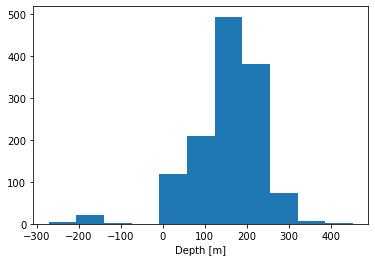

In [17]:
n, bins, patches = plt.hist(sondes['DEPTH'].values,11)
plt.xlabel('Depth [m]')

In [18]:
bins

array([-272.        , -206.09090909, -140.18181818,  -74.27272727,
         -8.36363636,   57.54545455,  123.45454545,  189.36363636,
        255.27272727,  321.18181818,  387.09090909,  453.        ])

We have both positive values and negative value for `DEPTH`. This means that sometimes ÀLTITUDE_MIN`and ÀLTITUDE_MAX`have been inverted. We use the `abs`foction to have positive values everywhere 

Text(0.5, 0, 'Depth [m]')

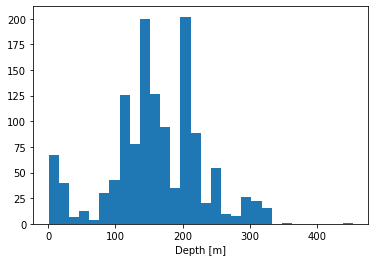

In [19]:
sondes['DEPTH'] = sondes['DEPTH'].abs()

bin = plt.hist(sondes['DEPTH'].values,30)
plt.xlabel('Depth [m]')


## Static visual exploration of the geothermal probes depth

We can use the `matplotlib` package to plot the coordinates of the probes cmapped bay the depth. The result will be someting like

Text(0, 0.5, 'Latitude')

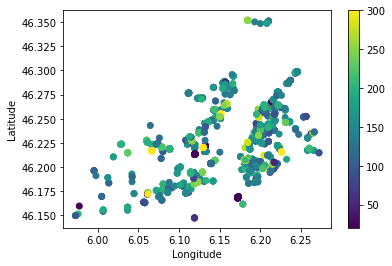

In [20]:
plt.scatter(sondes.lon, sondes.lat, c=sondes.DEPTH, vmin=20, vmax=300)
plt.colorbar()
plt.xlabel('Longitude')
plt.ylabel('Latitude')

This method gives us some information about the localization and depth, but it is visually difficult to interpret.

## Interactive visual exploration of the geothermal probes depth with `pydeck`


In [21]:
layer = pydeck.Layer(
    'ColumnLayer',  # `type` positional argument is here
    data=sondes,
    get_position=['lon', 'lat'],
    auto_highlight=True,
    get_elevation='DEPTH',
    elevation_scale=25,
    radius=50,
    pickable=True,
    get_fill_color = [69,162,128,255],
    coverage=2)

view_state = pydeck.ViewState(
    longitude=6.183829,
    latitude=46.194656,
    zoom=10,
    min_zoom=5,
    max_zoom=15,
    pitch=25,
    bearing=0)

# Combined all of it and render a viewport
r = pydeck.Deck(layers=[layer],
                height=1500, 
                initial_view_state=view_state,
#                 map_style='light'
#                 map_style='https://api.maptiler.com/maps/ch-swisstopo-lbm-grey/style.json?key=Y0QFvc1p5eTvlCMj4GEX'
               )
r.to_html('geothermal-probes-viz-1.html')

with some customization ...

In [30]:
COLOR_RANGE = [

    [49,54,149],
    [69,117,180],
    [116,173,209],
    [171,217,233],
    [224,243,248],
    [255,255,191],
    [254,224,144],
    [253,174,97],
    [244,109,67],
    [215,48,39],
    [165,0,38],
]

a
BREAKS = [30, 80, 130, 160,  190, 220, 250, 280,310,  340,370]


def color_scale(val):
    for i, b in enumerate(list(BREAKS)):
        if val < b:
            return COLOR_RANGE[i]
    return COLOR_RANGE[i]

sondes["fill_color"] = sondes["DEPTH"].apply(lambda x: color_scale(x))


In [46]:
layer = pydeck.Layer(
    'ColumnLayer',  # `type` positional argument is here
    data=sondes,
    get_position=['lon', 'lat'],
    auto_highlight=True,
    get_elevation='DEPTH',
    elevation_scale=25,
    radius=100,
    pickable=True,
    get_fill_color = "fill_color",

    coverage=2)


# Set the viewport location
view_state = pydeck.ViewState(
    longitude=6.183829,
    latitude=46.194656,
    zoom=10,
    
    min_zoom=5,
    max_zoom=15,
    pitch=45,
    bearing=0)

# Combined all of it and render a viewport
r = pydeck.Deck(layers=[layer],
                height=1500,
                initial_view_state=view_state,
                map_style='https://api.maptiler.com/maps/ch-swisstopo-lbm-grey/style.json?key=Y0QFvc1p5eTvlCMj4GEX'
               )
r.to_html('geothermal-probes-viz-custom.html')

In [45]:
import pydeck as pdk

HEXAGON_LAYER_DATA = (
    "https://raw.githubusercontent.com/visgl/deck.gl-data/master/examples/3d-heatmap/heatmap-data.csv"  # noqa
)

# Define a layer to display on a map
layer = pdk.Layer(
    "HexagonLayer",
    data=sondes,
    get_position=['lon', 'lat'],
    auto_highlight=True,
    elevation_scale=10,
    pickable=True,
    elevation_range=[0, 1500],
    extruded=True,
    radius=1000,
    coverage=1,
    color_range=COLOR_RANGE
)


# Render
r = pydeck.Deck(layers=[layer],
                height=1500,
                initial_view_state=view_state,
                map_style='https://api.maptiler.com/maps/ch-swisstopo-lbm-grey/style.json?key=Y0QFvc1p5eTvlCMj4GEX'
               )
r.to_html("geothermal-probes-viz-hexagon-bin-map.html.html")